In [8]:
from pr2_utils import *

In [9]:
dataset = 20

with np.load("../data/Encoders%d.npz"%dataset) as data:
    encoder_counts = data["counts"] # 4 x n encoder counts
    encoder_stamps = data["time_stamps"] # encoder time stamps

with np.load("../data/Imu%d.npz"%dataset) as data:
    imu_angular_velocity = data["angular_velocity"] # angular velocity in rad/sec
    imu_linear_acceleration = data["linear_acceleration"] # accelerations in gs (gravity acceleration scaling)
    imu_stamps = data["time_stamps"]  # acquisition times of the imu measurements

In [10]:
yaw = imu_angular_velocity[2,:].T
distance = np.cumsum(np.sum(encoder_counts, axis=0)/4*0.0022).T
f_distance = interp1d(encoder_stamps, distance, kind='linear')

In [11]:
n = imu_stamps.shape[0]

T_l = (imu_stamps[1:n-1] + imu_stamps[:n-2]) / 2
T_r = (imu_stamps[2:] + imu_stamps[1:n-1]) / 2
tau = (imu_stamps[2:] - imu_stamps[:n-2]) / 2

w_tau = yaw[1:n-1] * tau
v_tau = f_distance(T_r) - f_distance(T_l)

X = np.zeros([n-1, 3])
for i in range (1,n-1):
    X[i, :] = X[i-1, :] + np.array([
        v_tau[i-1] * np.sinc(w_tau[i-1]) * np.cos(X[i-1, 2] + w_tau[i-1] / 2),
        v_tau[i-1] * np.sinc(w_tau[i-1]) * np.sin(X[i-1, 2] + w_tau[i-1] / 2),
        w_tau[i-1]
    ])

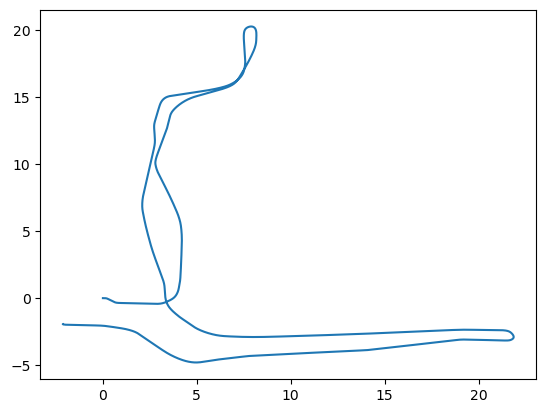

In [12]:
plt.plot(X[1:,0], X[1:,1])
plt.show()

In [13]:
X[1:].shape, imu_stamps[1:-1].shape

((12185, 3), (12185,))

In [14]:
np.savez(f'../data/odometry_imu_{dataset}.npz', X=X[1:], stamps=imu_stamps[1:-1])